In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from uavsar_pytools.snow_depth_inversion import depth_from_phase, phase_from_depth

In [2]:
def p_spatial(B, incidence_angle,r , Ry = 1.6, wavelength = 1.1):
    """
    B: spatial_baseline [m]
    Ry: range resolution [m] # 1.6 meters for uavsar
    incidence_angle: average look angle [radians]
    wavelength: radar wavelength [m]
    r = distance to target [m]
    """
    return 1 - 2 * np.abs(B) * Ry * np.cos(incidence_angle) ** 2 / (wavelength * r)

from scipy.special import spence
def phase_variance(cor):
    return (np.pi**2 /3) - (np.pi * np.arcsin(cor)) + np.arcsin(cor)**2 - spence(cor**2) /2

from scipy.special import gamma as G
from scipy.special import hyp2f1 
def phase_pdf(cor, L, phase, expected_phase = 0.0):
    return (G(L + 1/2) * (1 - cor**2)**L * cor * np.cos(phase - expected_phase)) / (2 * np.pi**0.5 * G(L) * (1 - cor**2 * np.cos(phase - expected_phase)**2)**(L+1/2)) + ((1 - cor**2)**L / (2 * np.pi)) * hyp2f1(L, 1, 0.5, cor**2 * np.cos(phase - expected_phase)**2)

def phase_pdf_timex(cor, L, phase, expected_phase = 0.0):
    return phase* phase_pdf(cor, L, phase)

def phase_pdf_timex2(cor, L, phase, expected_phase = 0.0):
    return phase**2 * phase_pdf(cor, L, phase)

# def phase_pdf_minus_mean(cor, L, mean, phase, xpected_phase = 0.3):
    # return phase_pdf_timex2(cor, L, phase) -  mean**2

Took Equation 59 in Rosen et al 2000 for the PDF of the phase. Integrated it multiplied by x across support -pi to pi so int(-np.pi, pi) x * f(x) to get expected value and then variance is just x**2 f(x) - u**2 where u is the mean. We could integrate those and get mean and variance for a certain set of looks and coherence to recrease figure 26 in Rosen et al.

In [3]:
import scipy.integrate as integrate
from functools import partial
def get_pdf_moments(cor, L):
    f = partial(phase_pdf_timex, cor, L)
    Ex = integrate.quad(f, -np.pi, np.pi)[0]
    f = partial(phase_pdf_timex2, cor, L)
    E2x = integrate.quad(f, -np.pi, np.pi)[0] - Ex
    return Ex, E2x**0.5

Text(0, 0.5, '$\\triangle$ SWE Uncertainty [%]')

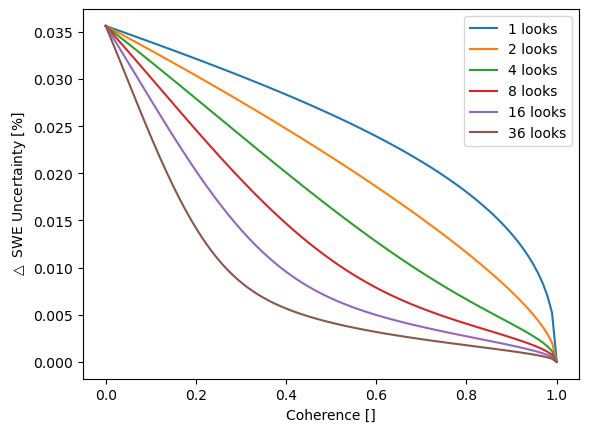

In [4]:
inc_angle = np.deg2rad(40)
density = 200
for L in [1, 2, 4, 8, 16, 36]:
    stds = []
    for cor in np.linspace(0, 0.99999, 100):
        mean, std = get_pdf_moments(cor = cor, L = L)
        std_sd = depth_from_phase(std, inc_angle = inc_angle, density = density)
        std_swe = std_sd * density / 997
        stds.append(std_swe)
    plt.plot(np.linspace(0, 1, 100), stds, label = f'{L} looks')
plt.legend()
plt.xlabel('Coherence []')
plt.ylabel('$\\triangle$ SWE Uncertainty [%]')

Text(0, 0.5, 'SWE Uncertainty [%] @ 36 Looks\nUAVSAR ~ 5m, NISAR ~ 50m Resolution')

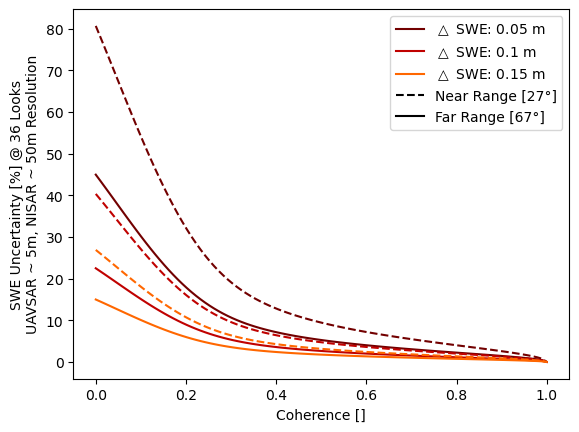

In [66]:
density = 200
# 30 meter resolution UAVSAR
L = 36
# 10 cm of swe change
swe_changes = np.array([0.05, 0.1, 0.15])
# average look in near = 27, in far = 67
near_inc, far_inc = 27, 67
incs = np.array([np.deg2rad(inc) for inc in [near_inc, far_inc]])
inc_dic = {27: 'near [27°]', 67: 'far [67°]'}
# phases = [phase_from_depth(dswe*997/200, incs, density=200) for dswe in swe_changes]
cors = np.linspace(0, 0.99999, 100)
cmap = mpl.colormaps['gist_heat']
colors = {0.05: cmap(0.3), 0.1: cmap(0.5),0.15:cmap(0.7)}
from itertools import product
for dswe, inc in product(swe_changes, incs):
    phase = phase_from_depth(dswe*997/200, incs, density=200)
    uncertainties = []
    for cor in cors:
        mean, std = get_pdf_moments(cor = cor, L = L)
        std_sd = depth_from_phase(std, inc_angle = inc, density = density)
        std_swe = std_sd * density / 997
        uncert_perc = std_swe / dswe * 100
        uncertainties.append(uncert_perc)
    inc = int(np.rad2deg(inc))
    if inc == 27: linestyle = 'dashed'
    else: linestyle = 'solid'
    label = f'$\\triangle$ SWE: {dswe} m'
    if inc == 27: label = '_' + label
    plt.plot(cors, uncertainties, label = label, linestyle = linestyle, color = colors[dswe])
# plt.plot(np.linspace(0, 1, 100), stds, label = f'{L} looks')
plt.plot([], [], linestyle = 'dashed', label = 'Near Range [27°]', color = 'black')
plt.plot([], [], linestyle = 'solid', label = 'Far Range [67°]', color = 'black')
plt.legend()
plt.xlabel('Coherence []')
plt.ylabel('SWE Uncertainty [%] @ 36 Looks\nUAVSAR ~ 5m, NISAR ~ 50m Resolution')

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating p

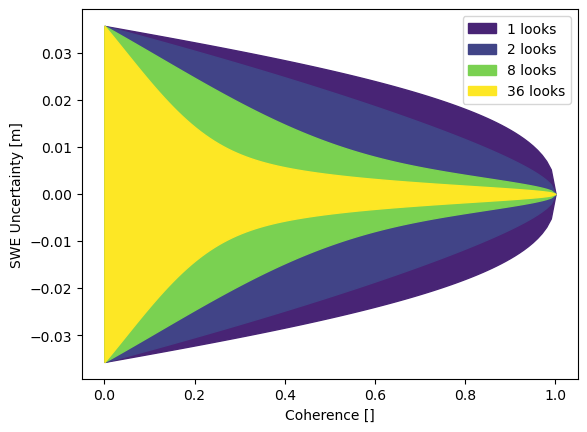

In [188]:
inc_angle = np.deg2rad(40)
density = 300
L = 36
true_swe = 0.0

cors = np.linspace(0, 0.99999, 100)
for look in [1,2, 8, 36]:
    bs = []
    ts = []
    for cor in cors:
        mean, std = get_pdf_moments(cor = cor, L = look)
        std_sd = depth_from_phase(std, inc_angle = inc_angle, density = density)
        std_swe = std_sd * density / 997
        bs.append(true_swe - std_swe)
        ts.append(true_swe + std_swe)
    # plt.plot(np.linspace(0, 1, 100), stds, label = f'{L} looks')
    # plt.legend()
    plt.fill_between(cors, bs, ts, label = f'{look} looks', color = mpl.colormaps['viridis'](look/10))
    plt.xlabel('Coherence []')
    plt.ylabel('SWE Uncertainty [m]')
plt.legend()

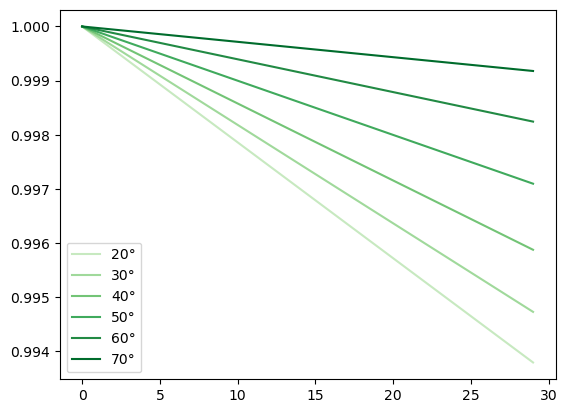

In [67]:
for inc in np.arange(20, 80, 10):
    plt.plot(np.arange(30), p_spatial(np.arange(30), incidence_angle = np.deg2rad(inc), r = 12000), label = f'{inc}°', color = mpl.colormaps['Greens'](inc/80))
plt.legend()

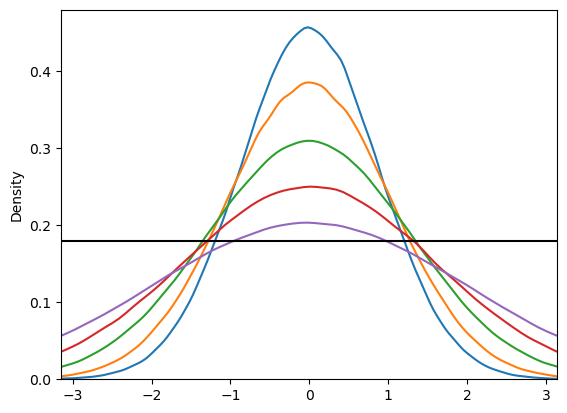

In [64]:
sns.kdeplot(np.random.normal(0, phase_variance(0.95), size = 1000000))
sns.kdeplot(np.random.normal(0, phase_variance(0.8), size = 1000000))
sns.kdeplot(np.random.normal(0, phase_variance(0.6), size = 1000000))
sns.kdeplot(np.random.normal(0, phase_variance(0.4), size = 1000000))
sns.kdeplot(np.random.normal(0, phase_variance(0.2), size = 1000000))

plt.xlim(-np.pi, np.pi)
plt.axhline(0.18, color = 'black')